In [1]:
import numpy as np
from scipy import stats
import math
from math import floor
import argparse
import matplotlib.pyplot as plt
import matplotlib
import os
import csv
import pymc as pm
import arviz as az
import warnings
import pandas as pd
import seaborn as sns

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
overall_percs = []
f_name = "overall_percs.csv"
ff_name = "true_pred.csv"

In [3]:
for i in range(100):
    try:
        # globals
        g_y = []
        g_y_pred = []
        g_num_groups = 0
        g_users = [] # model users
        s_users = [] # simulated users

        class Simulation:

            ## Fixed hyperparameters
            initial_users = 20
            initial_groups = 10
            initial_communities = 5

            # group and community preferences
            alpha_group_hyperparameter = 10
            beta_group_hyperparameter = 10 

            alpha_community_hyperparameter = 10
            beta_community_hyperparameter = 10

            comments_per_step = 1

                
            # Initialize lists to store users and groups
            users = []
            groups = []
            communities = []


            gis = {}
            cis = {}
            uis = {}

            def __init__(self, num_timesteps, user_growth_rate, interaction_threshold, new_group_rate, new_community_rate) -> None:

                self.users = []
                self.groups = []
                self.communities = []

                self.gis = {}
                self.cis = {}
                self.uis = {}

                self.num_timesteps = num_timesteps

                self.user_growth_rate = user_growth_rate

                self.interaction_threshold = interaction_threshold

                self.new_group_rate = new_group_rate
                self.new_group_join_chance = new_group_rate / 10

                self.new_community_rate = new_community_rate
                self.new_community_join_chance = new_community_rate / 10

                self.same_community_interaction_ratio = new_community_rate * new_group_rate

            class Community:
                def __init__(self, simulation, group=None):
                    self.simulation = simulation 
                    # Initialize a community with a list of users and groups
                    self.id = len(self.simulation.communities) + 1
                    self.groups = [group] if group else []
                    self.interactions = []

            class Group:
                def __init__(self, simulation):
                    self.simulation = simulation 
                    # Initialize a group with an ID and a dictionary tgo track user interactions
                    self.id = len(self.simulation.groups)
                    self.interactions = {}
                    self.community = None

                def join_community(self, community):
                    community.groups.append(self)
                    self.community = community

            class User:
                def __init__(self, group_alpha, group_beta, community_alpha, community_beta):
                    # Initialize a user with ID, group memberships, interaction history, and Beta distribution preferences
                    self.id = None

                    self.groups = []
                    self.communities = []
                    self.interaction_history = []

                    self.group_preferences = stats.beta(group_alpha, group_beta)
                    self.community_preferences = stats.beta(community_alpha, community_beta)
                    self.updated_preferences = np.array([1])

                def update_preferences(self):
                    # Update user's preferences based on group interactions
                    if not self.groups:
                        self.updated_preferences = np.array([1])
                        return
                    else:
                        #sort groups by number of interactions
                        self.groups.sort(key=lambda group: len(group.interactions))

                    total_size = sum([len(group.interactions) for group in self.groups])

                    # if size is 0, this must be the first iteration, return uniform
                    if total_size == 0:
                        self.ccdf = np.array([1])
                        return
                    else:
                        sizes = sorted([len(group.interactions) for group in self.groups])
                        self.ccdf = 1 - (np.cumsum(sizes) / total_size)

                    group_convolution = np.convolve(self.group_preferences.pdf(np.linspace(0, 1, len(self.groups))), self.ccdf , mode='same')

                    self.updated_preferences = np.convolve(group_convolution, self.community_preferences.pdf(np.linspace(0, 1, len(self.groups))), mode='same')

                    if np.isnan(self.updated_preferences).any() or np.sum(self.updated_preferences) == 0:
                        self.updated_preferences = np.array([1 / len(self.groups)] * len(self.groups))
                    else:
                        self.updated_preferences /= np.sum(self.updated_preferences)

                def join_group(self, group):
                    # Add a group to the user's group list and set initial interactions to 0
                    self.groups.append(group)
                    group.interactions[self] = 0

                def interact(self, group):
                    # Record an interaction with the specified group
                    group.interactions[self] = group.interactions.get(self, 0) + 1
                    self.interaction_history.append(group.id)
                    # if group.id == 0:
                    #     print("A", self.interaction_history[-1])

            # Recalculate probabilities at every iteration or after any changes
            def calculate_probabilities(self):
                global community_relative_frequency, group_relative_frequency

                community_relative_frequency = np.array([len(community.groups) for community in self.communities], dtype=float)
                # if community_relative_frequency.sum() != 0:
                community_relative_frequency += 1e-5  # Avoid division by zero
                community_relative_frequency /= community_relative_frequency.sum()

                group_relative_frequency = np.array([sum(group.interactions.values()) for group in self.groups], dtype=float)
                # if group_relative_frequency.sum() != 0:
                group_relative_frequency += 1e-5
                group_relative_frequency /= group_relative_frequency.sum()


            def initialize(self):

                # Initialize users
                for i in range(self.initial_users):
                    self.users.append(
                        self.User(
                            self.alpha_group_hyperparameter,
                            self.beta_group_hyperparameter,
                            self.alpha_community_hyperparameter,
                            self.beta_community_hyperparameter,
                        )
                    )
                    self.users[-1].id = len(self.users)

                # Initialize communities
                for i in range(self.initial_communities):
                    self.communities.append(self.Community(self))

                # Initialize groups
                for i in range(self.initial_groups):
                    self.groups.append(self.Group(self))

                # adding the first groups to each community so there is at least one group in each community
                for i in range(len(self.communities)):
                    self.groups[i].join_community(self.communities[i])
                    # random chance for each user to join the first group of a new community
                    for user in self.users:
                        if np.random.random() < self.new_community_join_chance:
                            user.join_group(self.groups[i])

                # randomly adding the rest of the groups to communities
                for group in self.groups[len(self.communities):]:
                    group.join_community(self.communities[np.random.randint(0, len(self.communities))])
                    for user in self.users:
                        if np.random.random() < self.new_group_join_chance:
                            user.join_group(group)

                # initialize dictionaries for each group, community, and user
                for group in self.groups:
                    self.gis[group.id] = []
                for community in self.communities:
                    self.cis[community.id] = []
                for user in self.users:
                    self.uis[user.id] = []

                
            def run(self):
                global s_users
                # main loop
                for time in range(self.num_timesteps):
                    # if time % 10 == 0:
                    #     print(f"Step: {time}", end = "\r")
                    # Calculate probabilities
                    self.calculate_probabilities()

                    # Add new users
                    new_users_count = floor(np.random.exponential(self.user_growth_rate))
                    for i in range(new_users_count):
                        self.users.append(
                            self.User(
                                self.alpha_group_hyperparameter,
                                self.beta_group_hyperparameter,
                                self.alpha_community_hyperparameter,
                                self.beta_community_hyperparameter,
                            )
                        )
                        self.users[-1].id = len(self.users)

                    # Add new groups
                    new_groups_count = floor(np.random.exponential(self.new_group_rate))
                    for i in range(new_groups_count):
                        self.groups.append(self.Group(self))

                        # # a new community always get made on the first time step
                        # if time == 0:
                        #     if new_groups_count == 0:
                        #         self.groups.append(self.Group(self))
                        #     self.groups[-1].join_community(self.communities[-1])
                        #     self.communities[-1].groups.append(self.groups[-1])
                        # else:
                        # check if the new group forms a new community
                        if np.random.random() < self.new_community_rate:
                            self.communities.append(self.Community(self, self.groups[-1]))
                            self.groups[-1].community = self.communities[-1]
                            # each user has a chance to join the new community
                            for user in self.users:
                                if np.random.random() < self.new_community_join_chance:
                                    user.join_group(self.groups[-1])
                            # users[np.random.randint(0, len(users))].join_group(groups[-1])
                        else:
                            # join a random community
                            self.groups[-1].join_community(self.communities[np.random.randint(0, len(self.communities))])

                    # Updating dictionaries with new groups, communities, and users
                    # and setting their initial values to 0
                    for group in self.groups:
                        if group.id not in self.gis:
                            self.gis[group.id] = [0]
                        self.gis[group.id].append(0)
                    for community in self.communities:
                        if community.id not in self.cis:
                            self.cis[community.id] = [0]
                        self.cis[community.id].append(0)
                    for user in self.users:
                        if user.id not in self.uis:
                            self.uis[user.id] = [0]
                        self.uis[user.id].append(0)

                    # Add new users to groups
                    for user in self.users:
                        self.calculate_probabilities()
                        # if there are groups for the user to join that they aren't in
                        # if a user is not in any group, they are guaranteed to join a group
                        if len(user.groups) == 0:
                            user.join_group(self.groups[np.random.choice(len(self.groups), p=group_relative_frequency)])
                        else:
                            if len(user.groups) < len(self.groups):
                                # join a group
                                if np.random.random() < self.new_group_join_chance:
                                    user.join_group(self.groups[np.random.choice(len(self.groups), p=group_relative_frequency)])

                    # Interact with groups
                    for user in self.users:
                        for _ in range(self.comments_per_step):
                            user.update_preferences()
                            interacted_groups = []
                            if np.random.uniform() < self.interaction_threshold and user.groups:
                                # print(user.updated_preferences)
                                group = np.random.choice(user.groups, p=user.updated_preferences)
                                # if group.id == 0:
                                #     print("Group 0")
                                user.interact(group)
                                self.gis[group.id][-1] += 1
                                self.cis[group.community.id][-1] += 1
                                self.uis[user.id][-1] += 1

                                # # potential bonus interactions within another group in the same community
                                # if group.community:
                                #     while True:
                                #         if np.random.uniform() < self.same_community_interaction_ratio:
                                #             community = group.community                    
                                #             group = np.random.choice(community.groups)
                                #             user.interact(group)
                                #             self.gis[group.id][-1] += 1
                                #             self.cis[group.community.id][-1] += 1
                                #             self.uis[user.id][-1] += 1
                                #         else:
                                #             break

                    # Update user preferences
                    for user in self.users:
                        if user.groups:
                            user.update_preferences()
                            if user.id == 0:
                                print(user.updated_preferences)
                                print(user.group_preferences.pdf(np.linspace(0, 1, len(user.groups))))
                        else:
                            user.updated_preferences = np.array([1])

            def plot(self, sim_number):        
                directory_name = f"{self.user_growth_rate}_{self.interaction_threshold}_{self.new_group_rate}_{self.new_community_rate}/{sim_number}"
                os.makedirs(directory_name, exist_ok=True)

                c_sum = []
                c_sum_labels = []
                for i in range(len(self.communities)):
                    temp_sum = [0] * self.num_timesteps
                    c_vals = np.cumsum(self.cis[i+1])
                    # add the values starting from the back
                    for j, val in enumerate(reversed(c_vals)):
                        temp_sum[-1-j] = val
                    c_sum.append(temp_sum)
                    c_sum_labels.append(list(self.cis.keys())[i])

                # print the final value for each community
                for c in c_sum_labels[:5]:
                    print(c, c_sum[c_sum_labels.index(c)][-1])
                    
                # finding the labels for the 5 largest communities
                top_5 = []
                top_5_labels = []
                for i in range(5):
                    max_val = 0
                    max_index = 0
                    for j in range(len(c_sum)):
                        if c_sum[j][-1] > max_val and c_sum_labels[j] not in top_5_labels:
                            max_val = c_sum[j][-1]
                            max_index = j
                    top_5.append(c_sum[max_index])
                    top_5_labels.append(c_sum_labels[max_index])

                for i in range(len(c_sum)):
                    if c_sum_labels[i] in top_5_labels:
                        plt.plot(c_sum[i][:len(c_sum[i])], label=f"C{i+1}")
                    else:
                        plt.plot(c_sum[i][:len(c_sum[i])], label=None)

                plt.legend(loc="upper left")
                plt.xlabel("Time")
                plt.ylabel("Cumulative Interactions")
                plt.yscale("log")
                plt.title("Cumulative Interactions of Each Community Over Time")
                plt.savefig(f"{directory_name}/community_interaction_growth.png")
                plt.close()
                
                # Scatter plot for final amount of interactions for each community
                c_sum_final = []
                c_sum_final_labels = []
                for i in range(len(self.communities)):
                    c_sum_final.append(c_sum[i][-1])
                    c_sum_final_labels.append(list(self.cis.keys())[i])

                plt.scatter(c_sum_final_labels, c_sum_final)
                plt.xlabel("Community")
                plt.ylabel("Final Cumulative Interactions")
                plt.title("Final Cumulative Interactions of Each Community")
                plt.savefig(f"{directory_name}/final_community_interactions.png")
                plt.close()
                

                g_sum = []
                g_sum_labels = []
                for i in range(1, len(self.groups)):
                    temp_sum = [0] * self.num_timesteps
                    g_vals = np.cumsum(self.gis[i])
                    # add the values starting from the back
                    for j, val in enumerate(reversed(g_vals)):
                        try:
                            temp_sum[j] = val
                        except:
                            pass

                    temp_sum = temp_sum[::-1]
                    g_sum.append(temp_sum)
                    g_sum_labels.append(list(self.gis.keys())[i])

                # print the final value for each group
                for g in g_sum_labels[:5]:
                    print(g, g_sum[g_sum_labels.index(g)][-1])

                # finding the labels for the 5 largest groups
                top_5 = []
                top_5_labels = []
                for i in range(5):
                    max_val = 0
                    max_index = 0
                    for j in range(len(g_sum)):
                        if g_sum[j][-1] > max_val and g_sum_labels[j] not in top_5_labels:
                            max_val = g_sum[j][-1]
                            max_index = j
                    top_5.append(g_sum[max_index])
                    top_5_labels.append(g_sum_labels[max_index])

                for i in range(len(g_sum)):
                    if g_sum_labels[i] in top_5_labels:
                        plt.plot(g_sum[i], label=f"G{i+1}")
                    else:
                        plt.plot(g_sum[i], label=None)

                plt.legend(loc="upper left")
                plt.xlabel("Time")
                plt.ylabel("Cumulative Interactions")
                # plt.yscale("log")
                plt.ylim(bottom=1)
                plt.title("Cumulative Interactions of Each Group Over Time")
                plt.savefig(f"{directory_name}/group_interaction_growth.png")
                plt.close()

                # Scatter plot for final amount of interactions for each group
                g_sum_final = []
                g_sum_final_labels = []
                for i in range(len(g_sum)):
                    g_sum_final.append(g_sum[i][-1])
                    g_sum_final_labels.append(list(self.gis.keys())[i])

                plt.scatter(g_sum_final_labels, g_sum_final)
                plt.xlabel("Group")
                plt.ylabel("Final Cumulative Interactions")
                plt.title("Final Cumulative Interactions of Each Group")
                plt.savefig(f"{directory_name}/final_group_interactions.png")
                plt.close()

                for u in self.uis:
                    self.uis[u] = self.uis[u][:self.num_timesteps]

                # plotting total amount of interactions for each user
                u_sum = []
                u_sum_labels = []
                for i in range(1, len(self.users)):
                    temp_sum = [0] * self.num_timesteps
                    u_vals = np.cumsum(self.uis[i])
                    # add the values starting from the back
                    for j, val in enumerate(reversed(u_vals)):
                        temp_sum[j] = val

                    temp_sum = temp_sum[::-1]
                    u_sum.append(temp_sum)
                    u_sum_labels.append(list(self.uis.keys())[i])

                # print the final value for each user
                for u in u_sum_labels[:5]:
                    print(u, u_sum[u_sum_labels.index(u)][-1])

                # finding the labels for the 5 largest users
                top_5 = []
                top_5_labels = []

                for i in range(5):
                    max_val = 0
                    max_index = 0
                    for j in range(len(u_sum)):
                        if u_sum[j][-1] > max_val and u_sum_labels[j] not in top_5_labels:
                            max_val = u_sum[j][-1]
                            max_index = j
                    top_5.append(u_sum[max_index])
                    top_5_labels.append(u_sum_labels[max_index])

                # Scatter plot for final amount of interactions for each user
                u_sum_final = []
                u_sum_final_labels = []
                for i in range(len(u_sum)):
                    u_sum_final.append(u_sum[i][-1])
                    u_sum_final_labels.append(list(self.uis.keys())[i])

                plt.scatter(u_sum_final_labels, u_sum_final)
                plt.xlabel("User")
                plt.ylabel("Final Cumulative Interactions")
                plt.title("Cumulative Interactions of Each User")
                plt.savefig(f"{directory_name}/final_user_interactions.png")
                plt.close()

            
            def write_data(self, sim_number):
                directory_name = f"{self.user_growth_rate}_{self.interaction_threshold}_{self.new_group_rate}_{self.new_community_rate}/{sim_number}"
                os.makedirs(directory_name, exist_ok=True)

                # Write User Interactions to CSV
                with open(f"{directory_name}/user_interactions.csv", 'w', newline='') as file:
                    writer = csv.writer(file)
                    for row in self.uis:
                        writer.writerow([row] + self.uis[row])

                    file.close()
                
                # Write Group Interactions to CSV
                with open(f"{directory_name}/group_interactions.csv", 'w', newline='') as file:
                    writer = csv.writer(file)
                    for row in self.gis:
                        writer.writerow([row] + self.gis[row])

                    file.close()

                # Write Community Interactions to CSV
                with open(f"{directory_name}/community_interactions.csv", 'w', newline='') as file:
                    writer = csv.writer(file)
                    for row in self.cis:
                        writer.writerow([row] + self.cis[row])

                    file.close()


                with open(f"{directory_name}/simulation_data.csv", 'w') as file:
                    writer = csv.writer(file)
                    writer.writerow(['num_users', 'num_groups', 'num_communities', 'num_interactions'])
                    writer.writerow([len(self.users), len(self.groups), len(self.communities), sum([len(group.interactions) for group in self.groups])])

                    file.close()

                print("Data written to CSV files.")

            def community_regression_model(self, sim_number): 
                directory_name = f"{self.user_growth_rate}_{self.interaction_threshold}_{self.new_group_rate}_{self.new_community_rate}/{sim_number}"
                os.makedirs(directory_name, exist_ok=True)
                # Initialize DataFrame with a consistent index
                X = pd.DataFrame(index=range(self.num_timesteps))

                # Constructing DataFrame X
                for community_id in range(1, len(self.communities) + 1):  # Group IDs are 1-indexed
                    # Retrieve group data and handle missing values
                    df = pd.DataFrame(self.cis[community_id]).fillna(0)
                    if len(df) < self.num_timesteps:
                        df = df.reindex(range(self.num_timesteps), fill_value=0)
                    X[f'community_{community_id}'] = df.squeeze()
                
                X = X.T

                # Target variable y (last column of X)
                y = X.iloc[:, -1].to_numpy()

                # Features (all columns except the last)
                X = X.iloc[:, :-1]

                print(X)

                # PyMC model
                model = pm.Model()
                with model:
                    try:
                        # Priors for unknown model parameters
                        alpha = pm.TruncatedNormal('alpha', lower=0, mu=0.5, sigma=10, shape=X.shape[0])
                        betas = pm.Normal('betas', mu=0.05, sigma=0.05, shape=X.shape[1])

                        # Expected value of outcome
                        mu = alpha + pm.math.dot(X, betas)

                        # Likelihood (sampling distribution) of observations
                        sigma = pm.Exponential('sigma', lam=1, shape=X.shape[0])
                        y_obs = pm.TruncatedNormal('y_obs', lower=0, mu=mu, sigma=sigma, observed=y, shape=X.shape[0])

                        # Sampling
                        trace = pm.sample(tune=5000,draws=5000, return_inferencedata=True)
                        posterior_predictive = pm.sample_posterior_predictive(trace)
                        prior_predictive = pm.sample_prior_predictive()


                    except pm.exceptions.SamplingError as e:
                        print(f"Sampling error: {e}")

                prior = prior_predictive['prior_predictive']['y_obs']

                # Check the shape of the prior predictive
                print("Shape of prior predictive:", prior.shape)

                # Adjust the code based on the shape of prior
                num_chains, num_draws, num_communities = prior.shape
                cs = [[] for _ in range(num_communities)]

                for chain in range(num_chains):
                    for draw in range(num_draws):
                        for c in range(num_communities):
                            cs[c].append(prior[chain, draw, c])


                for c in cs:
                    plt.hist(c)
                plt.show()

                pred = posterior_predictive['posterior_predictive']['y_obs'].to_numpy()

                shape = pred.shape
                comms = shape[2]

                # Initialize list of lists for each community
                preds = [[] for _ in range(comms)]

                for i in range(shape[0]):
                    for j in range(shape[1]):
                        for k in range(comms):
                            preds[k].append(pred[i, j, k])

                for k in range(comms):

                    plt.hist(preds[k], bins=50, alpha=0.5)
                    plt.axvline(y[k], color='k', linestyle='dashed', linewidth=1)
                    plt.title('Community Interaction Predictions')
                    plt.xlabel("Number of interactions")
                    plt.ylabel("Frequency")
                plt.show()
                    
                print(az.summary(trace))

                az.plot_trace(trace)
                plt.show()

                
                trace_df = az.summary(trace)
                trace_df.to_csv(f'{directory_name}/community_trace.csv')

            
            def group_regression_model(self,sim_number):
                directory_name = f"{self.user_growth_rate}_{self.interaction_threshold}_{self.new_group_rate}_{self.new_community_rate}/{sim_number}"
                os.makedirs(directory_name, exist_ok=True)
                
                X = pd.DataFrame(index=range(self.num_timesteps))

                # Constructing DataFrame X
                for group_id in range(1, len(self.groups)):
                    # Retrieve group data and handle missing values
                    df = pd.DataFrame(self.gis[group_id]).fillna(0)
                    if len(df) < self.num_timesteps:
                        df = df.reindex(range(self.num_timesteps), fill_value=0)
                    X[f'group_{group_id}'] = df.squeeze()
                
                X = X.T

                # Target variable y (last column of X)
                y = X.iloc[:, -1].to_numpy()

                # Features (all columns except the last)
                X = X.iloc[:, :-1]

                print(X)

                model = pm.Model()

                with model:
                    try:
                        # Priors for unknown model parameters
                        alpha = pm.TruncatedNormal('alpha', lower=0, mu=0.5, sigma=10, shape=X.shape[0])
                        betas = pm.Normal('betas', mu=0.05, sigma=0.05, shape=X.shape[1])

                        # Expected value of outcome
                        mu = alpha + pm.math.dot(X, betas)

                        # Likelihood (sampling distribution) of observations
                        sigma = pm.Exponential('sigma', lam=1, shape=X.shape[0])
                        y_obs = pm.TruncatedNormal('y_obs', lower=0, mu=mu, sigma=sigma, observed=y, shape=X.shape[0])

                        # Sampling
                        trace = pm.sample(tune=5000,draws=5000, return_inferencedata=True)
                        posterior_predictive = pm.sample_posterior_predictive(trace)
                        prior_predictive = pm.sample_prior_predictive()
                    
                    except pm.exceptions.SamplingError:
                        warnings.warn('SamplingError: Skipping this group')

                prior = prior_predictive['prior_predictive']['y_obs']

                gs = [[] for _ in range(len(self.groups))]

                for chain in range(prior.shape[0]):
                    for draw in range(prior.shape[1]):
                        for g in range(prior.shape[2]):
                            gs[g].append(prior[chain,draw,g])

                for g in gs:
                    plt.hist(g)
                plt.show()

                pred = posterior_predictive['posterior_predictive']['y_obs'].to_numpy()

                shape = pred.shape
                groups1 = shape[2]

                # Initialize list of lists for each community
                preds = [[] for _ in range(groups1)]

                for i in range(shape[0]):
                    for j in range(shape[1]):
                        for k in range(groups1):
                            preds[k].append(pred[i, j, k])

                for k in range(groups1):

                    plt.hist(preds[k], bins=50, alpha=0.5)
                    plt.axvline(y[k], color='k', linestyle='dashed', linewidth=1)
                    plt.title('Group Interaction Predictions')
                    plt.xlabel("Number of interactions")
                    plt.ylabel("Frequency")
                plt.show()
                    
                print(az.summary(trace))

                az.plot_trace(trace)
                plt.show()
                
                trace_df = az.summary(trace)
                trace_df.to_csv(f'{directory_name}/group_trace.csv')

            
            def user_choice_model(self,sim_number):
                global g_y, g_y_pred, g_num_groups, g_users
                unique = 0
                directory_name = f"{self.user_growth_rate}_{self.interaction_threshold}_{self.new_group_rate}_{self.new_community_rate}/{sim_number}"
                os.makedirs(directory_name, exist_ok=True)
                # multinomial logit model for group interactions
                num_groups = len(self.groups)
                g_num_groups = num_groups
                y = []
                X = []

                for user in self.users:
                    if len(user.interaction_history) == 0:
                        y.append(0)
                    else:
                        y.append(user.interaction_history[-1])
                    # every interaction but the last one
                    # X.append(np.bincount(user.interaction_history[:-1], minlength=num_groups))
                    X.append(user.interaction_history[:-1])


                X = pd.DataFrame(X)
                X.fillna(0, inplace=True)
                # print(X[:5])

                y = pd.DataFrame(y)
                y = y.iloc[:,0].to_numpy()        


                # drop first column if sum is 0
                # if X.iloc[:,0].sum() == 0:
                #     X = X.iloc[:,1:]
                #     if num_groups < X.shape[1]:
                #         num_groups += (X.shape[1] - num_groups)
                #     elif num_groups > X.shape[1]:
                #         num_groups -= (num_groups - X.shape[1])
                    
                #     if X.shape[1] < np.max(y):
                #         y -= (np.max(y)- X.shape[1]) 

                # for row in range(len(X)):
                #     X.iloc[row] = X.iloc[row] / X.iloc[row].sum()

                # X.fillna(0, inplace=True)
                # print(X[:5])

                # X = (X - X.mean()) / X.std()
                # X.fillna(0, inplace=True)


                model = pm.Model()

                # print(X[:5])
                # print(y[:5])


                with model:
                    try:

                        indices = pm.Data('index', list(range(len(X))), dims='user')
                        # Define your data within the model
                        X_data = pm.Data('X_data', X)
                        y_data = pm.Data('y_data', y)

                        print(X_data)
                        print(y_data)

                        unique_values, unique_counts = np.unique(y, return_counts=True)
                        # print("unique counts", unique_values)
                        unique = len(unique_values)
                        # if unique < 5:
                        #     return None, None, None, None, None
                        # print("unique values", unique_counts)

                        # Model parameters              
                        alpha = pm.Exponential('alpha', lam=.1, shape=num_groups)

                        beta_mu = pm.Normal('beta_mu', mu=1, sigma=10, shape=num_groups)
                        beta_sd = pm.TruncatedNormal('beta_sd', lower=0, mu=5, sigma=2.5, shape=num_groups)

                        beta = pm.Normal('beta', mu=beta_mu, sigma=beta_sd, shape=(num_groups, num_groups))

                        # Computing mu
                        mu = alpha + pm.math.dot(X_data, beta) 

                        # A numerically stable softmax
                        mu_max = pm.math.max(mu, axis=1, keepdims=True)
                        p = pm.Deterministic('p', pm.math.exp(mu - mu_max) / pm.math.sum(pm.math.exp(mu - mu_max), axis=1, keepdims=True))

                        # Categorical distribution for observed data
                        y_obs = pm.Categorical('y_obs', p=p, observed=y_data, dims='user')

                        # Sampling
                        trace = pm.sample(tune=1000, draws=1000)
                        posterior_predictive = pm.sample_posterior_predictive(trace)
                        prior_predictive = pm.sample_prior_predictive()

                    except pm.exceptions.SamplingError:
                        model.debug(verbose=True)
                    
                    # print(az.summary(trace))

                    # az.plot_trace(trace)
                    # plt.show()

                    g_y = y
                    g_y_pred = np.rint(posterior_predictive['posterior_predictive']['y_obs'].mean(axis=(0,1)))

                    y_pred = np.rint(posterior_predictive['posterior_predictive']['y_obs'].mean(axis=(0,1))) 

                    # print(az.summary(trace))

                    samples = posterior_predictive['posterior_predictive']['y_obs'].to_numpy()
                    users = [[] for _ in range(samples.shape[2])]
                    for chain in range(samples.shape[0]):
                        for draw in range(samples.shape[1]):
                            for user in range(samples.shape[2]):
                                users[user].append(samples[chain, draw, user])


                    # Define the grid layout
                    num_users = len(users)
                    num_rows = int(num_users**0.5)  # Number of rows in the grid
                    num_cols = (num_users + num_rows - 1) // num_rows  # Number of columns in the grid

                    g_users = users
                    
                    # # Create subplots
                    # fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10)

                    # # Iterate through users and plot histograms
                    # for user_idx, ax in enumerate(axes.flat):
                    #     if user_idx < num_users:
                    #         user_data = users[user_idx]
                    #         actual_interaction = y[user_idx]

                    #         ax.hist(user_data, bins=num_groups)
                    #         ax.axvline(actual_interaction, color='r', linestyle='dashed', linewidth=1)

                    #         ax.set_title(f'User {user_idx + 1}')
                    #         ax.set_xlabel('Interactions')
                    #         ax.set_ylabel('Frequency')

                    # # Remove any empty subplots
                    # for user_idx in range(num_users, num_rows * num_cols):
                    #     fig.delaxes(axes.flat[user_idx])

                    # plt.tight_layout()
                    # plt.show()

                    trace_df = az.summary(trace)
                    trace_df.to_csv(f'{directory_name}/user_trace.csv')

                return model, trace, posterior_predictive, prior_predictive, p

        # sim = Simulation(50, 1.5, 1.01, 0.25, 0.1)
        # sim.initialize()
        # sim.run()

        # sim_number = np.random.randint(1, 10000)

        # sim.user_choice_model(sim_number)
        # sim.community_regression_model(sim_number)
        # sim.group_regression_model(sim_number)
        # sim.plot(sim_number)

        
        # num_timesteps, user_growth_rate, interaction_threshold, new_group_rate, new_community_rate
        inp_vals = [100, 0.75, 1.0, 0.2, 0.1]
        # inp_vals = [100, 1.5, 1.01, 0.35 , 0.25]
        folder_string = f"{inp_vals[1]}_{inp_vals[2]}_{inp_vals[3]}_{inp_vals[4]}"
        sim = Simulation(inp_vals[0], inp_vals[1], inp_vals[2], inp_vals[3], inp_vals[4])
        sim.initialize()
        sim.run()

        sim_number = 1

        model, trace, posterior_pred, prior_pred, p = sim.user_choice_model(sim_number)

        g_y = np.array(g_y)
        g_y_pred = np.array(g_y_pred)

        # varying point sizes based on frequencies of unique pairs
        g_y_unique_pairs, g_pair_counts = np.unique(
            list(zip(g_y, g_y_pred)), axis=0, return_counts=True
        )
        g_y_point_sizes = (g_pair_counts * 100) + 25

        # overall_percs.append(np.mean(g_y == g_y_pred) * 100)

        # adding to end of csv file
        with open(f_name, 'a') as f:
            writer = csv.writer(f)
            writer.writerow([np.mean(g_y == g_y_pred) * 100])
            f.close()

        # adding to end of csv file
        with open(ff_name, 'a') as f:
            writer = csv.writer(f)
            writer.writerow([g_y, g_y_pred])
            f.close()

        # Percentage of correct predictions
        print(f"Percentage of correct predictions: {np.mean(g_y == g_y_pred) * 100}%")

        sns.set(style="darkgrid")

        plt.figure(figsize=(8, 8))
        plt.scatter(g_y_unique_pairs[:, 0], g_y_unique_pairs[:, 1], s=g_y_point_sizes)
        plt.xlabel("Actual Group ID")
        plt.ylabel("Predicted Group ID")
        plt.title("Actual vs. Predicted Group IDs")
        plt.plot(
            [0, max(max(g_y_unique_pairs[:, 0]), max(g_y_unique_pairs[:, 1]))],
            [0, max(max(g_y_unique_pairs[:, 0]), max(g_y_unique_pairs[:, 1]))],
            color="k",
            linestyle="dashed",
            linewidth=1,
        )

        # each point with the count of occurrences
        for i, pair in enumerate(g_y_unique_pairs):
            count = g_pair_counts[i]
            plt.text(
                pair[0],
                pair[1],
                str(count),
                ha="center",
                va="center",
                fontsize=12,
                color="white",
            )

        # plt.savefig(f"{folder_string}/actual_vs_predicted.png")
        plt.show()

    except:
        continue

c:\Users\gian\miniconda3\envs\treten\lib\site-packages\pymc\data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


X_data{[[9. 9. 9. ... 0. 0. 0.]]}
y_data{[9 3 8 4 8 ... 8 4 8 0 8]}
X_data{[[5. 5. 5. ... 0. 0. 0.]]}
y_data{[5 8 6 4 1 ... 6 1 4 6 1]}
X_data{[[2. 2. 2. ... 0. 0. 0.]]}
y_data{[5 4 7 9 9 ... 9 8 1 3 2]}
X_data{[[6. 6. 6. ... 0. 0. 0.]]}
y_data{[6 1 6 0 3 ... 0 9 4 0 9]}
X_data{[[9. 9. 9. ... 0. 0. 0.]]}
y_data{[9 6 9 6 8 ... 6 8 6 6 0]}
X_data{[[6. 6. 6. ... 0. 0. 0.]]}
y_data{[6 6 1 5 3 ... 5 7 7 4 3]}
X_data{[[6. 6. 6. ... 0. 0. 0.]]}
y_data{[9 5 7 7 9 ... 6 6 2 9 9]}
X_data{[[1. 1. 1. ... 0. 0. 0.]]}
y_data{[1 4 5 4 5 ... 7 6 5 0 2]}


Percentage of correct predictions: 87.75510204081633%


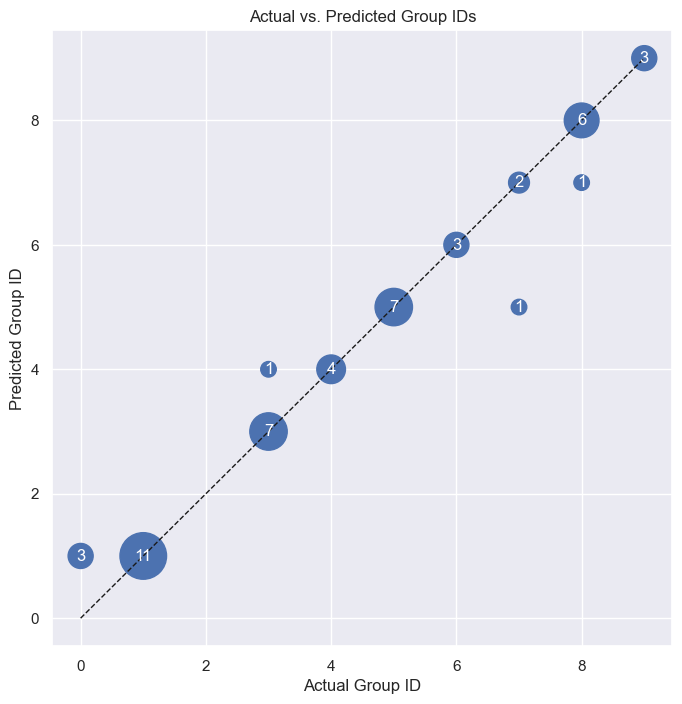

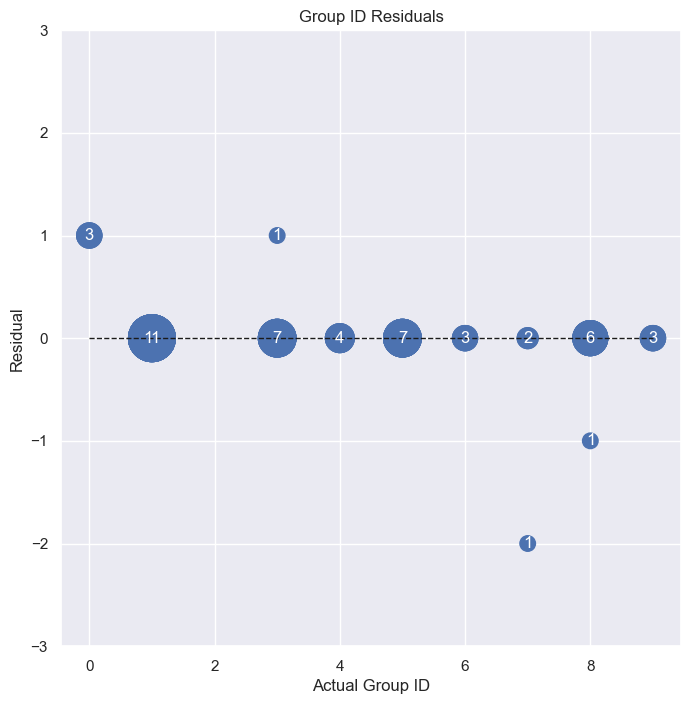

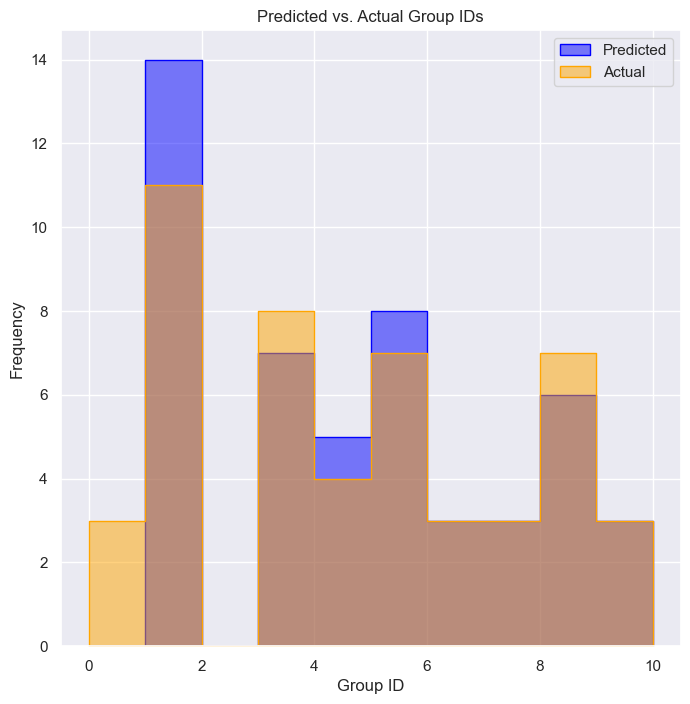

In [289]:
g_y = np.array(g_y)
g_y_pred = np.array(g_y_pred)

# print(g_y)
# print(g_y_pred)

# varying point sizes based on frequencies of unique pairs
g_y_unique_pairs, g_pair_counts = np.unique(
    list(zip(g_y, g_y_pred)), axis=0, return_counts=True
)
g_y_point_sizes = (g_pair_counts * 100) + 25

# Percentage of correct predictions
print(f"Percentage of correct predictions: {np.mean(g_y == g_y_pred) * 100}%")

sns.set(style="darkgrid")

plt.figure(figsize=(8, 8))
plt.scatter(g_y_unique_pairs[:, 0], g_y_unique_pairs[:, 1], s=g_y_point_sizes)
plt.xlabel("Actual Group ID")
plt.ylabel("Predicted Group ID")
plt.title("Actual vs. Predicted Group IDs")
plt.plot(
    [0, max(max(g_y_unique_pairs[:, 0]), max(g_y_unique_pairs[:, 1]))],
    [0, max(max(g_y_unique_pairs[:, 0]), max(g_y_unique_pairs[:, 1]))],
    color="k",
    linestyle="dashed",
    linewidth=1,
)

# each point with the count of occurrences
for i, pair in enumerate(g_y_unique_pairs):
    count = g_pair_counts[i]
    plt.text(
        pair[0],
        pair[1],
        str(count),
        ha="center",
        va="center",
        fontsize=12,
        color="white",
    )

plt.savefig(f"{folder_string}/actual_vs_predicted.png")
plt.show()

# varying point sizes based on frequencies of residuals
g_y_resids = g_y_pred - g_y
g_y_vals = list(zip(g_y, g_y_pred))
g_y_unique_pairs, g_pair_counts = np.unique(g_y_vals, axis=0, return_counts=True)
pair_count_dict = {
    tuple(pair): count for pair, count in zip(g_y_unique_pairs, g_pair_counts)
}
g_y_point_sizes = [((pair_count_dict[tuple(pair)] * 100) + 25) for pair in g_y_vals]

max_abs_val = max(abs(g_y_resids))

plt.figure(figsize=(8, 8))
plt.scatter(g_y, g_y_resids, s=g_y_point_sizes)
plt.ylim(-max_abs_val - 1, max_abs_val + 1)
plt.xlabel("Actual Group ID")
plt.ylabel("Residual")
plt.title("Group ID Residuals")
plt.plot(
    [0, max(max(g_y), max(g_y_pred))],
    [0, 0],
    color="k",
    linestyle="dashed",
    linewidth=1,
)

already_placed = []
for i, val in enumerate(g_y_vals):
    if val in already_placed:
        continue
    count = pair_count_dict[tuple(val)]
    plt.text(
        val[0],
        g_y_resids[i],
        str(count),
        ha="center",
        va="center",
        fontsize=12,
        color="white",
    )
    already_placed.append(val)

plt.savefig(f"{folder_string}/residuals.png")
plt.show()

common_range = (min(min(g_y_pred), min(g_y)), max(max(g_y_pred), max(g_y)))
bin_amt = int(max(common_range) - min(common_range)) + 1

plt.figure(figsize=(8, 8))
sns.histplot(
    g_y_pred,
    bins=bin_amt,
    alpha=0.5,
    label="Predicted",
    color="blue",
    element="step",
    binrange=(0, bin_amt),
)
sns.histplot(
    g_y,
    bins=bin_amt,
    alpha=0.5,
    label="Actual",
    color="orange",
    element="step",
    binrange=(0, bin_amt),
)
plt.legend()
plt.xlabel("Group ID")
plt.ylabel("Frequency")
plt.title("Predicted vs. Actual Group IDs")
plt.savefig(f"{folder_string}/predicted_vs_actual.png")
plt.show()

In [250]:
# g_users = np.array(g_users)

# # Define the grid layout
# num_users = len(g_users)
# num_rows = int(num_users**0.5)  # Number of rows in the grid
# num_cols = (num_users + num_rows - 1) // num_rows  # Number of columns in the grid

# # Create subplots
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# # Iterate through users and plot histograms
# for user_idx, ax in enumerate(axes.flat):
#     if user_idx < num_users:
#         user_data = g_users[user_idx]
#         actual_interaction = g_y[user_idx]

#         ax.hist(user_data, bins=g_num_groups)
#         ax.axvline(actual_interaction, color='r', linestyle='dashed', linewidth=1)

#         ax.set_title(f'User {user_idx + 1}')
#         ax.set_xlabel('Interactions')
#         ax.set_ylabel('Frequency')

# # Remove any empty subplots
# for user_idx in range(num_users, num_rows * num_cols):
#     fig.delaxes(axes.flat[user_idx])

# plt.tight_layout()
# plt.show()

[0 1 2 3 4 5 6 7 8 9]
{1: 101, 2: 100, 3: 103, 4: 100, 5: 102, 6: 103, 7: 101, 8: 102, 9: 106, 10: 102, 11: 101, 12: 102, 13: 101, 14: 101, 15: 105, 16: 101, 17: 104, 18: 101, 19: 104, 20: 102, 21: 91, 22: 92, 23: 91, 24: 94, 25: 90, 26: 92, 27: 89, 28: 80, 29: 64, 30: 67, 31: 62, 32: 53, 33: 51, 34: 46, 35: 49, 36: 46, 37: 45, 38: 43, 39: 37, 40: 30, 41: 30, 42: 27, 43: 12, 44: 12, 45: 12, 46: 10, 47: 4, 48: 2, 49: 2}


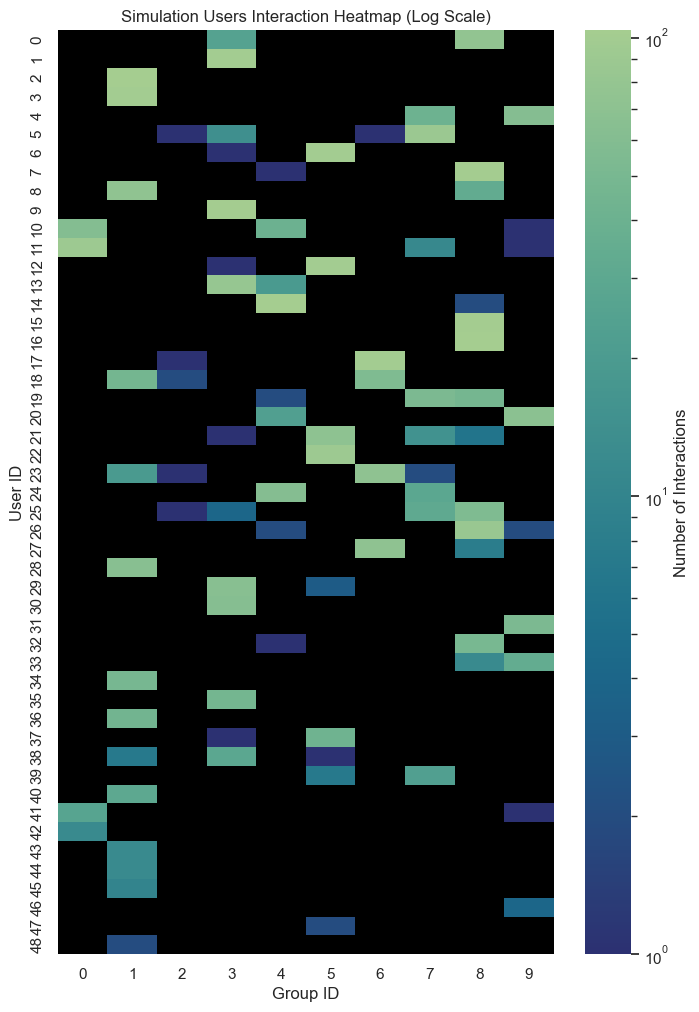

[188. 572.   6. 532. 252. 416. 301. 292. 681. 225.]


In [258]:
sim_users = sim.users
sim_users_interaction_history = [user.interaction_history for user in sim_users]
# print unqiue values for all users
unique_vals = []
for user in sim_users_interaction_history:
    cur_unique_vals = np.unique(user)
    for val in cur_unique_vals:
        unique_vals.append(val)
unique_vals = np.unique(unique_vals)
print(unique_vals)

# dict with user id and total count of interactions
sim_users_interaction_count = {user.id: len(user.interaction_history) for user in sim_users}
print(sim_users_interaction_count)


# similar to the above code, but for the simulation data
# Define the grid layout
num_users = len(sim_users_interaction_history)
num_rows = int(num_users**0.5)  # Number of rows in the grid
num_cols = (num_users + num_rows - 1) // num_rows  # Number of columns in the grid

sim_interaction_data = np.zeros((num_users, g_num_groups))

# Fill the matrix with user interaction data
for user_idx, user_data in enumerate(sim_users_interaction_history):
    for group_id in user_data:
        sim_interaction_data[user_idx, group_id] += 1

mask = (sim_interaction_data == 0)

# Find non-empty rows and columns (users and groups with interactions)
non_empty_rows = np.where(~np.all(sim_interaction_data == 0, axis=1))[0]
# non_empty_cols = np.where(~np.all(sim_interaction_data == 0, axis=0))[0]

# Filter the interaction data and mask based on non-empty rows and columns
filtered_sim_interaction_data = sim_interaction_data[non_empty_rows][:,] # [:, non_empty_cols]
filtered_mask = mask[non_empty_rows][:,] # [:, non_empty_cols]

cmap = sns.color_palette("crest", as_cmap=True).reversed()
cmap.set_bad(color='black')

# Create the heatmap
plt.figure(figsize=(8, 12))
sns.heatmap(
    filtered_sim_interaction_data,
    cmap=cmap,
    norm=matplotlib.colors.LogNorm(vmin=1, vmax=filtered_sim_interaction_data.max()),
    mask = filtered_mask,
    cbar_kws={"label": "Number of Interactions"},
    cbar=True,
    fmt=".0f",
    # xticklabels=non_empty_cols,
    yticklabels=non_empty_rows, 
)

plt.xlabel("Group ID")
plt.ylabel("User ID")
plt.title("User Interaction Heatmap")
plt.title("Simulation Users Interaction Heatmap (Log Scale)")
plt.savefig(f"{folder_string}/sim_user_interaction_heatmap.png")
plt.show()

sim_group_sum = np.sum(sim_interaction_data, axis=0)
print(sim_group_sum)

(49, 10)


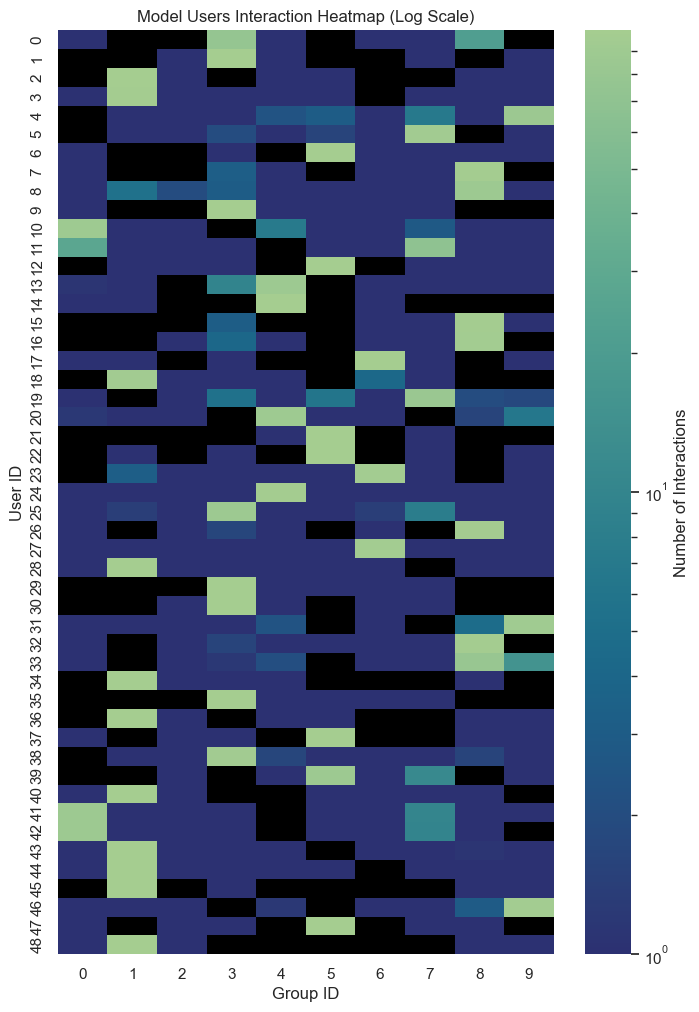

[ 299.6 1094.1   11.8  792.1  395.6  700.5  305.9  301.4  696.   303. ]


In [260]:
# Create a matrix to store the interaction data for each user
interaction_data = np.zeros((num_users, g_num_groups))

print(interaction_data.shape)
# print(g_users)
# Fill the matrix with user interaction data
for user_idx, user_data in enumerate(g_users):
    # print(user_data)
    for group_id in user_data:
        interaction_data[user_idx, group_id] += 1

# dividing each row by 1000
interaction_data = interaction_data / 10

mask = (interaction_data == 0)

# Filter the interaction data and mask based on non-empty rows and columns
filtered_interaction_data = interaction_data[non_empty_rows][:,] # [:, non_empty_cols]
filtered_mask = mask[non_empty_rows][:,] #[:, non_empty_cols]

cmap = sns.color_palette("crest", as_cmap=True).reversed()
cmap.set_bad(color='black')

# print unique values of filtered_interaction data
unique, counts = np.unique(filtered_interaction_data, return_counts=True)
# print("unique values", unique)

# Create the heatmap
plt.figure(figsize=(8, 12))
sns.heatmap(
    filtered_interaction_data,
    cmap=cmap,
    norm=matplotlib.colors.LogNorm(vmin=1, vmax=filtered_interaction_data.max()),
    mask = filtered_mask,
    cbar_kws={"label": "Number of Interactions"},
    cbar=True,
    fmt=".0f",
    # xticklabels=non_empty_cols,
    yticklabels=non_empty_rows,
)

plt.xlabel("Group ID")
plt.ylabel("User ID")
plt.title("User Interaction Heatmap")
plt.title("Model Users Interaction Heatmap (Log Scale)")
plt.savefig(f"{folder_string}/model_user_interaction_heatmap.png")
plt.show()

model_group_sum = np.sum(interaction_data, axis=0)
print(model_group_sum)

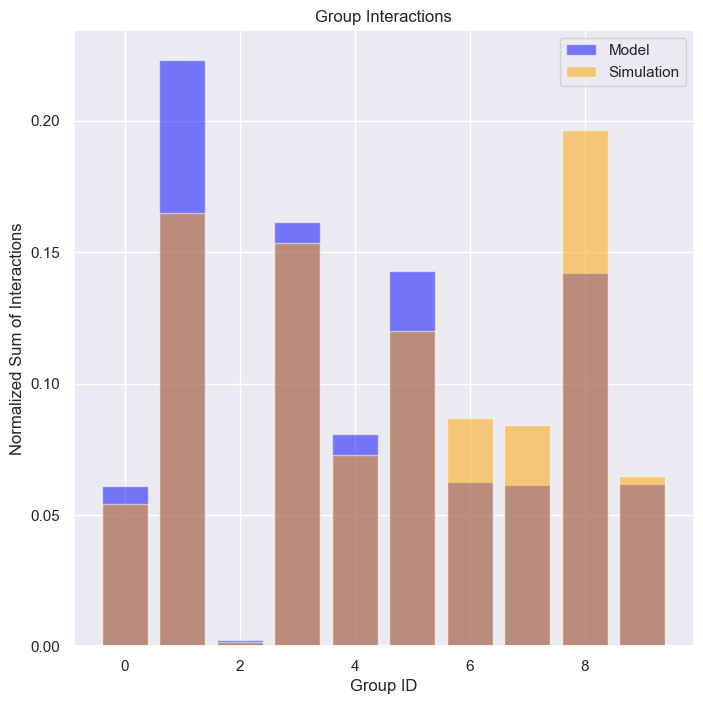

In [291]:
# common_range = (min(min(g_y_pred), min(g_y)), max(max(g_y_pred), max(g_y)))
# bin_amt = int(max(common_range) - min(common_range)) + 1

# plt.figure(figsize=(8, 8))
# sns.histplot(
#     g_y_pred,
#     bins=bin_amt,
#     alpha=0.5,
#     label="Predicted",
#     color="blue",
#     element="step",
#     binrange=(0, bin_amt),
# )
# sns.histplot(
#     g_y,
#     bins=bin_amt,
#     alpha=0.5,
#     label="Actual",
#     color="orange",
#     element="step",
#     binrange=(0, bin_amt),
# )
# plt.legend()
# plt.xlabel("Group ID")
# plt.ylabel("Frequency")
# plt.title("Predicted vs. Actual Group IDs")
# plt.savefig(f"{folder_string}/predicted_vs_actual.png")
# plt.show()

# ploting the simulation and model group sums
plt.figure(figsize=(8, 8))

sim_group_sum_norm = sim_group_sum / np.sum(sim_group_sum)
model_group_sum_norm = model_group_sum / np.sum(model_group_sum)

# bar plot
plt.bar(np.arange(len(model_group_sum)), model_group_sum_norm, alpha=0.5, label="Model", color="blue")
plt.bar(np.arange(len(sim_group_sum)), sim_group_sum_norm, alpha=0.5, label="Simulation", color="orange")
plt.xlabel("Group ID")
plt.ylabel("Normalized Sum of Interactions")
plt.title("Group Interactions")
plt.legend()
plt.savefig(f"{folder_string}/sim_vs_model_group_sum.png")
plt.show()



In [253]:
# # finding the probability that the sim_users most intereacted with group is the same as the model's
# print(sim_interaction_data)
# print(interaction_data)

sim_user_most_interacted = []
for user in sim_interaction_data:
    # print(user)
    sim_user_most_interacted.append(np.argmax(user))

# print(sim_user_most_interacted)

model_user_most_interacted = []
for user in interaction_data:
    model_user_most_interacted.append(np.argmax(user))

# print(model_user_most_interacted)

same = 0
for i in range(len(sim_user_most_interacted)):
    if sim_user_most_interacted[i] == model_user_most_interacted[i]:
        same += 1

print("Probability that the model's most interacted with group is the same as the simulation's")
print(same / len(sim_user_most_interacted))

Probability that the model's most interacted with group is the same as the simulation's
0.8163265306122449


[0.7959183673469388, 0.8979591836734694, 0.8367346938775511, 0.7755102040816326, 0.7959183673469388, 0.7551020408163265, 0.6122448979591837, 0.7346938775510204, 0.6530612244897959, 0.7959183673469388, 0.7346938775510204, 0.7959183673469388, 0.7142857142857143, 0.6938775510204082, 0.6326530612244898, 0.6326530612244898, 0.6326530612244898, 0.6326530612244898, 0.673469387755102, 0.6122448979591837, 0.673469387755102, 0.6938775510204082, 0.673469387755102, 0.6122448979591837, 0.5918367346938775, 0.5510204081632653, 0.7142857142857143, 0.6530612244897959, 0.5714285714285714, 0.6530612244897959, 0.6326530612244898, 0.5918367346938775, 0.5918367346938775, 0.6122448979591837, 0.5510204081632653, 0.6938775510204082, 0.5510204081632653, 0.5102040816326531, 0.5306122448979592, 0.5918367346938775, 0.5510204081632653, 0.6122448979591837, 0.6326530612244898, 0.6326530612244898, 0.5510204081632653, 0.5714285714285714, 0.5714285714285714, 0.5102040816326531, 0.5918367346938775]


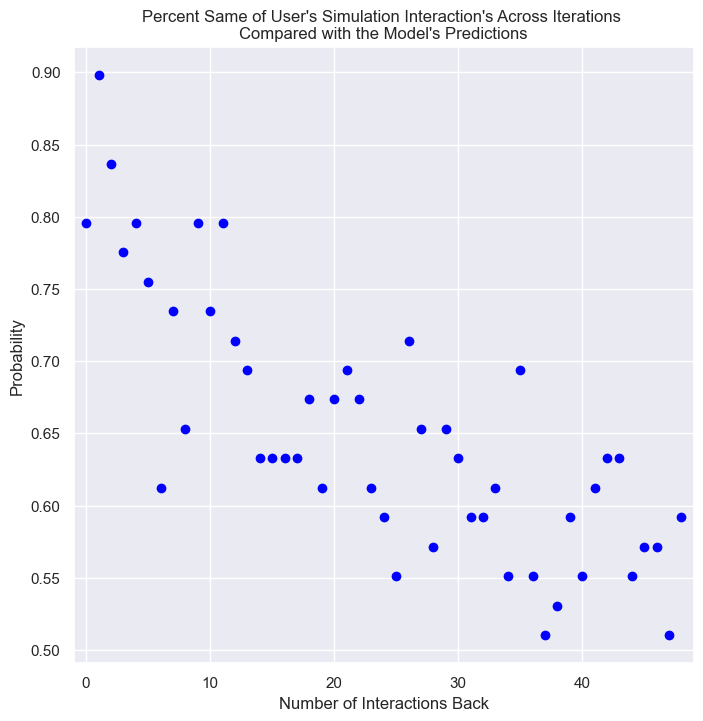

In [288]:
percs = []
for i in range(len(sim_users_interaction_history)):
    sim_users_last_intereacted = []
    for user in sim_users_interaction_history:
        # print(user)
        try:
            sim_users_last_intereacted.append(user[-i])
        except:
            sim_users_last_intereacted.append(-1)

    model_users_last_intereacted = []
    for user in g_users:
        try:
            model_users_last_intereacted.append(user[-i])
        except:
            model_users_last_intereacted.append(-1)

    same = 0
    for i in range(len(sim_users_last_intereacted)):
        if sim_users_last_intereacted[i] == model_users_last_intereacted[i]:
            if sim_users_last_intereacted[i] != -1:
                same += 1

    # print("Probability that the model's second to last interacted with group is the same as the simulation's")
    # print(same / len(sim_users_last_intereacted))
    percs.append(same / len(sim_users_last_intereacted))

print(percs)

plt.figure(figsize=(8, 8))
plt.scatter(np.arange(len(percs)), percs, color='blue', marker='o')
plt.xlabel("Number of Interactions Back")
plt.ylabel("Probability")
plt.title("Percent Same of User's Simulation Interaction's Across Iterations \nCompared with the Model's Predictions")

# Add gridlines and set precise limits for x and y axes
plt.grid(True)
plt.xlim(0-1, len(percs))
# plt.ylim(0, 1)

plt.savefig(f"{folder_string}/back_prob.png")
plt.show()

In [255]:


print(g_y)
print(g_y_pred)

same = 0
for i in range(len(sim_users_last_intereacted)):
    if g_y[i] == g_y_pred[i]:
        same += 1

print("Probability that the model's last interacted with group is the same as the simulation's")
print(same / len(sim_users_last_intereacted))

[3 3 1 1 9 7 5 8 8 3 0 7 5 4 4 8 8 6 1 7 4 5 5 6 4 3 8 6 1 3 3 9 8 8 1 3 1
 5 3 5 1 0 0 1 1 1 9 5 1]
[4. 3. 1. 1. 9. 7. 5. 8. 7. 3. 1. 5. 5. 4. 4. 8. 8. 6. 1. 7. 4. 5. 5. 6.
 4. 3. 8. 6. 1. 3. 3. 9. 8. 8. 1. 3. 1. 5. 3. 5. 1. 1. 1. 1. 1. 1. 9. 5.
 1.]
Probability that the model's last interacted with group is the same as the simulation's
0.8775510204081632


(4, 250, 49, 10)


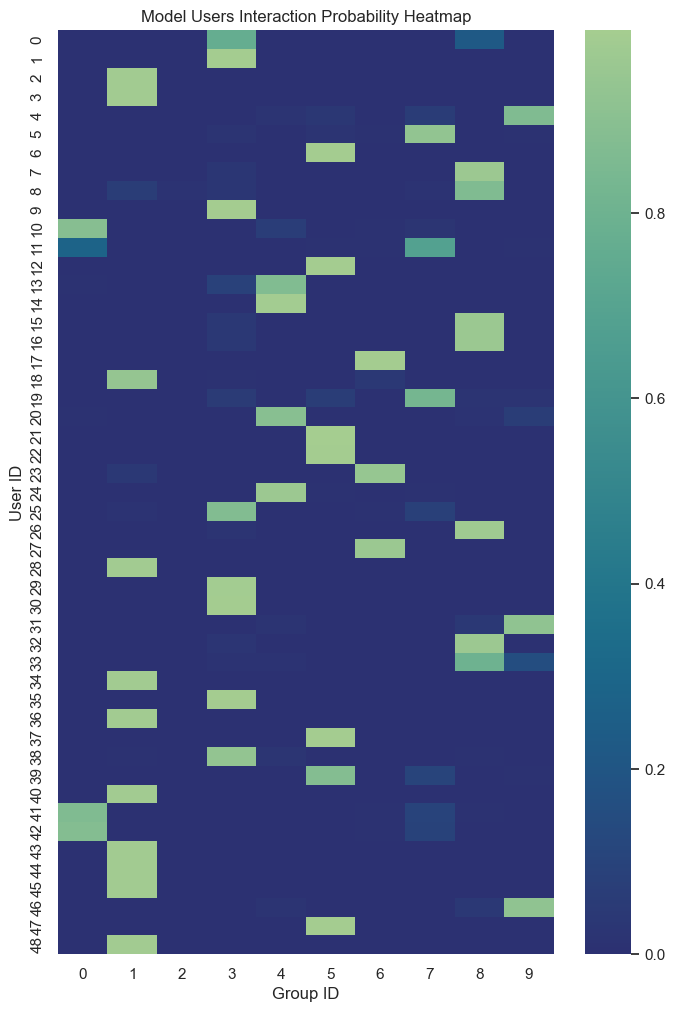

In [257]:
print(trace.posterior.p.shape)
# rows user, column groups
# (4, 1000, 141, 16)

post_shape = trace.posterior.p.shape
nmpy_arr = trace.posterior.p.values
flattened = nmpy_arr.reshape(post_shape[0] * post_shape[1], post_shape[2], post_shape[3])
flattened = flattened[:, :, :]
# remove any values that are 0
flattened = flattened.mean(axis=0)

plt.figure(figsize=(8, 12))
# plt.imshow(flattened, cmap=cmap)
sns.heatmap(
    flattened,
    cmap=cmap,
)

plt.xlabel("Group ID")
plt.ylabel("User ID")
plt.title("User Interaction Heatmap")
plt.title("Model Users Interaction Probability Heatmap")
plt.savefig(f"{folder_string}/model_user_interaction_heatmap_posterior.png")
plt.show()